In [26]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly.io as pio

import ChannelAttribution

In [2]:
# dataset courtsey Morten Hegewald
# https://www.dropbox.com/sh/m5d8u7inolw32xu/AADuHNcGToa7ajTcF_JjEkcca?dl=0
raw_data = pd.read_csv("attribution data.csv")
df = raw_data.copy()
df.head()

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search


In [3]:
df.shape

(586737, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586737 entries, 0 to 586736
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cookie            586737 non-null  object 
 1   time              586737 non-null  object 
 2   interaction       586737 non-null  object 
 3   conversion        586737 non-null  int64  
 4   conversion_value  586737 non-null  float64
 5   channel           586737 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 26.9+ MB


Text(0.5, 1.0, 'Channel Distribution')

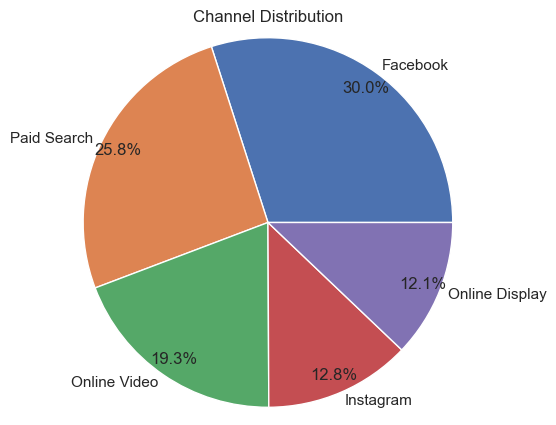

In [5]:
# representation of channels
plt.figure(figsize=(5,5))
plt.pie(df['channel'].value_counts(), labels = list(df['channel'].value_counts().keys())
,autopct = '%1.1f%%',radius = 1.2,pctdistance = 0.9, labeldistance = 1.05)
plt.title('Channel Distribution', loc = 'center') 

In [6]:
# channel and conversion crosstab analysis
pd.crosstab(df['channel'], df['conversion'], normalize = 'index').round(4)*100

conversion,0,1
channel,,
Facebook,96.98,3.02
Instagram,97.02,2.98
Online Display,96.99,3.01
Online Video,96.99,3.01
Paid Search,97.00,3.00


In [7]:
# channel and conversion crosstab analysis (vertical)
pd.crosstab(df['channel'], df['conversion'], normalize = 'columns').round(4)*100

conversion,0,1
channel,,
Facebook,29.95,30.05
Instagram,12.82,12.72
Online Display,12.11,12.13
Online Video,19.31,19.32
Paid Search,25.81,25.78


This looks like a balanced dataset in terms of channels. This might be because the data set was artificially created or sampled from original set. In any case, this will lead to various algorithms projecting similar attribution. Hence we will atrificially introduce some imbalance in one of the channels to see hoe the deviation impacts the attributions. 
In this case, we will focus on Instagram as a channel and reduce its conversions by a fair margin.

In [8]:
remove_n = 1500
drop_indices = np.random.choice(df.loc[(df['channel'] == 'Instagram') & (df['conversion'] == 1)].index, remove_n, replace=False)
df = df.drop(drop_indices)

In [9]:
# channel and conversion crosstab analysis
pd.crosstab(df['channel'], df['conversion'], normalize = 'index').round(4)*100

conversion,0,1
channel,,
Facebook,96.98,3.02
Instagram,98.99,1.01
Online Display,96.99,3.01
Online Video,96.99,3.01
Paid Search,97.00,3.00


We can now see that Instagram last touch conversions has been reduced from 3 to 1%. Last touch attibution will reflect this in terms of attribution. However, in terms of channel role, we now know that instagram plays a stronger role at mid funnel as a player and a data led attribution model should rightly reflect that.

In [11]:
# creating a channel stack and corresponding conversions
temp = df.groupby('cookie')['channel'].aggregate(lambda x: x.tolist()).reset_index()
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion']]
temp = pd.merge(temp, df_last_interaction, how='left', on='cookie')[['channel', 'conversion']]
temp.head()

,channel,conversion
0,"[Instagram, Online Display, Online Display, On...",0
1,"[Paid Search, Paid Search, Paid Search, Paid S...",0
2,"[Paid Search, Paid Search, Paid Search, Paid S...",0
3,[Instagram],0
4,[Paid Search],0


In [12]:
# creating a string path from list and some cleaning 
temp['path'] = temp['channel'].apply(str)
for i in temp.index:
    temp.at[i, 'path'] = temp.at[i, 'path'].replace('[','')
    temp.at[i, 'path'] = temp.at[i, 'path'].replace(']','')
    temp.at[i, 'path'] = temp.at[i, 'path'].replace(',','>')

In [15]:
temp1 = pd.crosstab(temp['path'], temp['conversion']).reset_index()
temp1.head()

conversion,path,0,1
0,'Facebook',32948,2054
1,'Facebook'> 'Facebook',7479,538
2,'Facebook'> 'Facebook'> 'Facebook',2095,230
3,'Facebook'> 'Facebook'> 'Facebook'> 'Facebook',761,85
4,'Facebook'> 'Facebook'> 'Facebook'> 'Facebook'...,322,41


In [17]:
# Final paths dataframe
df_path = pd.DataFrame()
df_path['path'] = temp1['path']
df_path['total_conversion'] = temp1[1]
df_path['total_null'] = temp1[0]
df_path.head()

,path,total_conversion,total_null
0,'Facebook',2054,32948
1,'Facebook'> 'Facebook',538,7479
2,'Facebook'> 'Facebook'> 'Facebook',230,2095
3,'Facebook'> 'Facebook'> 'Facebook'> 'Facebook',85,761
4,'Facebook'> 'Facebook'> 'Facebook'> 'Facebook'...,41,322


In [23]:
# heuristic models : first touch, last touch and linear 
H = ChannelAttribution.heuristic_models(df_path, 'path', 'total_conversion')
H

,channel_name,first_touch,last_touch,linear_touch
0,'Facebook',4666.0,5301.0,4830.235095
1,'Instagram',1487.0,744.0,1249.401202
2,'Online Display',2118.0,2139.0,2099.613833
3,'Online Video',3181.0,3408.0,3322.373196
4,'Paid Search',4687.0,4547.0,4637.376674


In [34]:
M = ChannelAttribution.auto_markov_model(df_path, 'path', 'total_conversion', 'total_null')
M

Suggested order not found. Try increasing max_order.
Number of simulations: 100000 - Reaching convergence (wait...): 7.05% > 5.00%
Number of simulations: 150000 - Reaching convergence (wait...): 6.22% > 5.00%
Number of simulations: 225000 - Reaching convergence (wait...): 5.04% > 5.00%
Number of simulations: 337500 - Convergence reached: 4.52% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (118) is reached: 99.99%


,channel_name,total_conversions
0,'Facebook',4819.944772
1,'Instagram',2293.803691
2,'Online Display',2008.662348
3,'Online Video',2821.843214
4,'Paid Search',4194.745976


In [36]:
R=pd.merge(H,M,on="channel_name",how="inner")
R1=R[["channel_name","first_touch","last_touch",\
"linear_touch","total_conversions"]]
R1.columns=["channel_name","first_touch","last_touch","linear_touch","markov_model"]
R1=pd.melt(R1, id_vars="channel_name")
data = [dict(
type = "histogram",
histfunc="sum",
x = R1.channel_name,
y = R1.value,
transforms = [dict(
type = "groupby",
groups = R1.variable,
)],
)]
fig = dict({"data":data})
pio.show(fig,validate=False)